In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
transform = transforms.ToTensor()
dataset = datasets.FashionMNIST(root = "./data", train= True, download= True, transform=transform)
loader = torch.utils.data.DataLoader(dataset=dataset,batch_size = 32, shuffle = True)


In [ ]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
         

        self.encoder = torch.nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )
         

        self.decoder = torch.nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()


        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*7*7, 64),
            nn.ReLU(),
            nn.Linear(64, 16)  # BottleNeck
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 32*7*7),
            nn.ReLU()
        )
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 7, 7))
        self.conv_decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   
            nn.Sigmoid() 
        )
        

    def forward(self,x):
        x = self.encoder(x)


        x = self.decoder(x)
        x = self.unflatten(x)
        x = self.conv_decoder(x)
        
        return x
    

            

In [11]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = AE().to(device)

model = ConvAE().to(device)

loss_func = nn.MSELoss()

optimizer = optim.Adam(model.parameters(),lr = 0.001,weight_decay= 1e-8)


Epoch [1/100], Loss: 0.0105
Epoch [2/100], Loss: 0.0095
Epoch [3/100], Loss: 0.0120
Epoch [4/100], Loss: 0.0111
Epoch [5/100], Loss: 0.0119
Epoch [6/100], Loss: 0.0077
Epoch [7/100], Loss: 0.0083
Epoch [8/100], Loss: 0.0083
Epoch [9/100], Loss: 0.0084
Epoch [10/100], Loss: 0.0062
Epoch [11/100], Loss: 0.0099
Epoch [12/100], Loss: 0.0098
Epoch [13/100], Loss: 0.0091
Epoch [14/100], Loss: 0.0086
Epoch [15/100], Loss: 0.0093
Epoch [16/100], Loss: 0.0090
Epoch [17/100], Loss: 0.0111
Epoch [18/100], Loss: 0.0121
Epoch [19/100], Loss: 0.0087
Epoch [20/100], Loss: 0.0086
Epoch [21/100], Loss: 0.0088
Epoch [22/100], Loss: 0.0099
Epoch [23/100], Loss: 0.0103
Epoch [24/100], Loss: 0.0082
Epoch [25/100], Loss: 0.0101
Epoch [26/100], Loss: 0.0082
Epoch [27/100], Loss: 0.0082
Epoch [28/100], Loss: 0.0086
Epoch [29/100], Loss: 0.0104
Epoch [30/100], Loss: 0.0101
Epoch [31/100], Loss: 0.0075
Epoch [32/100], Loss: 0.0074
Epoch [33/100], Loss: 0.0081
Epoch [34/100], Loss: 0.0088
Epoch [35/100], Loss: 0

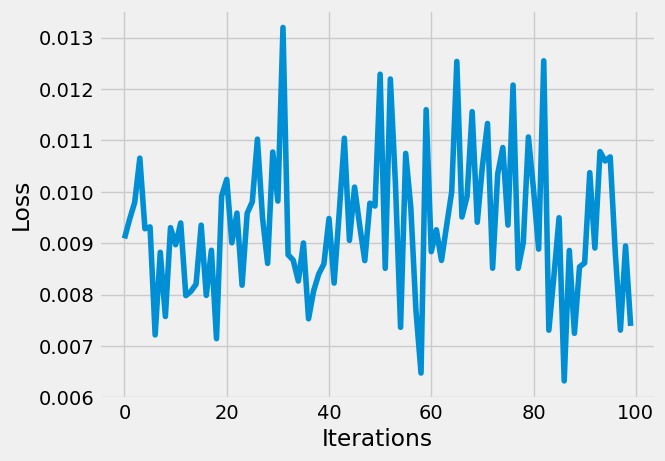

In [ ]:
epochs = 100
outputs = []
losses = []
for epoch in range(epochs):
    for (image, _) in loader:
      
      # Reshaping the image to (-1, 784)
      # image = image.to(device).reshape(-1,28*28)  # For AE

      image = image.to(device).view(-1,1,28,28) # For ConvAE
       
      reconstructed = model(image)
       
      loss = loss_func(reconstructed, image)
       
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
       
 
      losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    outputs.append((epochs, image, reconstructed))
    
 

plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 

plt.plot(losses[-100:])
plt.show()

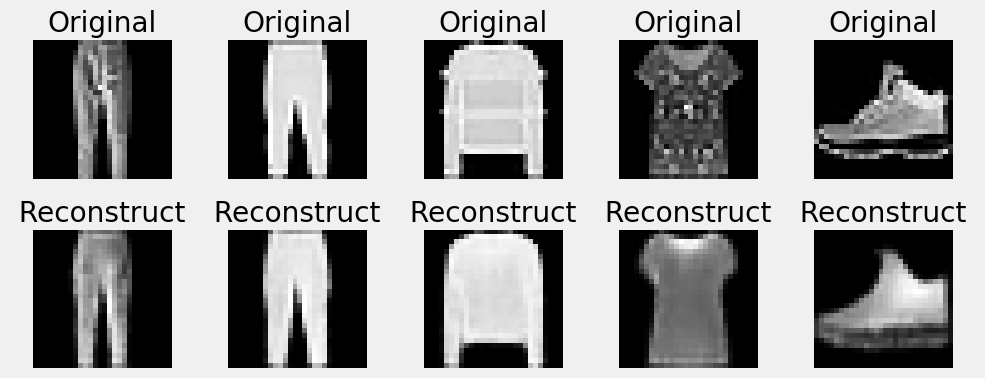

In [ ]:
import matplotlib.pyplot as plt


n = 5  
plt.figure(figsize=(10, 4))


for i in range(n):
    item = image[i].cpu().detach().numpy().reshape(28, 28)  
    plt.subplot(2, n, i + 1)  
    plt.imshow(item, cmap='gray')
    plt.title("Original")
    plt.axis("off")


for i in range(n):
    item = reconstructed[i].cpu().detach().numpy().reshape(28, 28)  
    plt.subplot(2, n, i + 1 + n)  
    plt.imshow(item, cmap='gray')
    plt.title(" Reconstruct ")
    plt.axis("off")

plt.tight_layout()

plt.savefig("original_vs_reconstructed_arch_change_100e.png", format="png")
plt.show()